In [1]:
import numpy as onp
import scipy.io
from scipy.interpolate import griddata
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax import config
from jax.flatten_util import ravel_pytree
from jax.nn import relu, elu
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
# Define MLP
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define modified MLP
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b
    
  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs
     

In [ ]:
# Define Physics-informed DeepONet model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []
        # Define DeepONet architecture
        #前向传播
    def operator_net(self, params, u, t, x):
        branch_params, trunk_params = params
        y = np.stack([t, x], axis=-1)  # 修正这里的维度
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
    
    # Define ds/dx
    #定义一阶导数，用于边界损失和物理残差的计算。
    def s_x_net(self, params, u, t, x):
         s_x = grad(self.operator_net, argnums=3)(params, u, t, x)#grad 是 JAX 库中的自动微分函数#grad(f, argnums=n) 返回函数 f 对第 n 个参数的导数，是自动微分工具，常用于物理方程残差和神经网络训练。
         return s_x
    
    # Define PDE residual   
    # 用于边界损失和物理残差的计算。     
    # def residual_net(self, params, u, t, x):
    #     s = self.operator_net(params, u, t, x)
    #     s_t = grad(self.operator_net, argnums=2)(params, u, t, x)
    #     s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
    #     s_xx= grad(grad(self.operator_net, argnums=3), argnums=3)(params, u, t, x)

    #     res = s_t + s * s_x - 0.01 * s_xx##粘性系数为0.01
    #     return res
    # 修改 PI_DeepONet 类中的 residual_net 方法
    def residual_net(self, params, u, t, x):
        # 计算 u (即 s)
        s = self.operator_net(params, u, t, x)
        
        # 计算 u 对 t 的一阶导数 (u_t)
        s_t = grad(self.operator_net, argnums=2)(params, u, t, x)
        
        # 计算 u 对 x 的二阶导数 (u_xx)
        s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
        s_xx = grad(grad(self.operator_net, argnums=3), argnums=3)(params, u, t, x)

        # Allen-Cahn 方程: u_t - 0.0001 * u_xx + 5 * u^3 - 5 * u = 0
        # 请根据你的数据集实际参数调整 0.0001 和 5
        reaction = 10
        
        res = s_t -  s_xx + reaction * (s**3 - s)
        return res
    # 修改 PI_DeepONet 类中的 loss_bcs 方法
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        
        # y 的结构应该是 [t, x_left, t, x_right]
        # 对应 generate_one_bcs_training_data 中的 y1(x=0) 和 y2(x=1)

        # 预测左边界 (x=0) 的 u 值
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # 预测右边界 (x=1) 的 u 值
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        # 预测左边界的导数 u_x
        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # 预测右边界的导数 u_x
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        # 周期性边界损失：左边值等于右边值，左边导数等于右边导数
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2)

        return loss_s_bc + loss_s_x_bc
    
        #pou损失
    def loss_pou(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        t, x = y[:,0], y[:,1]
        branch_params, trunk_params = params
        y = np.stack([t, x], axis=-1)  # 修正这里的维度
        T = self.trunk_apply(trunk_params, y)
        phi_sum = np.sqrt(np.sum(T**2, axis=-1))
        loss = np.mean((phi_sum - 1)**2)
        return loss  

    # Define initial loss
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss
    
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # 预测左边界 (x=0) 的 u 值
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # 预测右边界 (x=1) 的 u 值
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        # 预测左边界的导数 u_x
        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # 预测右边界的导数 u_x
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        # 周期性边界损失
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2)

        return loss_s_bc + loss_s_x_bc
    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss   
    
    def loss_data(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss
        

    # Define total loss
    # 损失函数
    def loss(self, params, ics_batch, bcs_batch, res_batch, pou_batch, data_batch, lambda_pou):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss_pou = self.loss_pou(params, pou_batch)
        loss_data = self.loss_data(params, data_batch)
        loss =  20*loss_data  + loss_ics + loss_bcs + loss_res #修改参数
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch, pou_batch, data_batch, lambda_pou):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch, pou_batch, data_batch, lambda_pou)
        return self.opt_update(i, g, opt_state)
    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, pou_dataset, data_dataset, lambda_pou, nIter=10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)
        pou_data = iter(pou_dataset)
        data_data = iter(data_dataset)

        pbar = trange(nIter)
        self.test_loss_log = []
        # Main training loop
        for it in pbar:
            # Fetch data
            ics_batch= next(ics_data)
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)
            pou_batch = next(pou_data)
            data_batch = next(data_data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, bcs_batch, res_batch ,pou_batch, data_batch ,lambda_pou)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss_data(params, data_batch)
                test_loss = self.loss_data(params,test_data_batch)
                # Store losses
                self.loss_log.append(loss_value)
                self.test_loss_log.append(test_loss)

                # Print losses
                # pbar.set_postfix({'Loss': loss_value, 
                #                 'loss_ics' : loss_ics_value,
                #                 'loss_bcs' : loss_bcs_value, 
                #                 'loss_physics': loss_res_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred




In [5]:

# Geneate ics training data corresponding to one input sample
def generate_one_ics_training_data(key, u0, m=101, P=101):# 生成ics初始条件

    t_0 = np.zeros((P,1))
    x_0 = np.linspace(0, 1, P)[:, None]

    y = np.hstack([t_0, x_0])
    u = np.tile(u0, (P, 1))
    s = u0

    return u, y, s
#新增
def generate_one_pou_training_data(key, m=101, P=100):
    # 随机采样时间和空间点
    t_pou = random.uniform(key, (P, 1))
    x_pou = random.uniform(key, (P, 1))
    y = np.hstack([t_pou, x_pou])  # shape = (P, 2)
    u = np.zeros((P, m))           # 不参与pou_loss计算
    s = np.zeros((P, 1))           # 不参与pou_loss计算
    return u, y, s
# 确保 generate_one_bcs_training_data 如下所示：
def generate_one_bcs_training_data(key, u0, m=101, P=100):
    # 随机采样时间 t
    t_bc = random.uniform(key, (P,1))
    
    # 定义左边界 x=0 和 右边界 x=1
    x_bc1 = np.zeros((P, 1))
    x_bc2 = np.ones((P, 1))
  
    # 堆叠数据
    y1 = np.hstack([t_bc, x_bc1])  # (P, 2)
    y2 = np.hstack([t_bc, x_bc2])  # (P, 2)

    u = np.tile(u0, (P, 1))
    # 将 y1 和 y2 拼在一起传入网络，以便在 loss_bcs 中拆分
    y = np.hstack([y1, y2])        # (P, 4) -> [t, 0, t, 1]
    s = np.zeros((P, 1))           # 占位符，不计算损失

    return u, y, s
# Geneate res training data corresponding to one input sample
def generate_one_res_training_data(key, u0, m=101, P=1000):

    subkeys = random.split(key, 2)
   
    t_res = random.uniform(subkeys[0], (P,1))
    x_res = random.uniform(subkeys[1], (P,1))

    u = np.tile(u0, (P, 1))
    y =  np.hstack([t_res, x_res])
    s = np.zeros((P, 1))

    return u, y, s

# Geneate test data corresponding to one input sample
def generate_one_test_data(idx, usol, m=101, P=101):
    u = usol[idx]
    u0 = u[0, :]
    
    t = np.linspace(0, 1, P)
    x = np.linspace(0, 1, P)
    T, X = np.meshgrid(t, x)
    
    s = u.T.flatten()
    u_out = np.tile(u0, (P**2, 1))
    y_out = np.hstack([T.flatten()[:, None], X.flatten()[:, None]])
    
    return u_out, y_out, s
#新增
def generate_one_data_training_data(key, u_full, m=101, P=100):

    Nt, Nx = u_full.shape 
    subkeys = random.split(key, 2)
    t_idx = random.randint(subkeys[0], (P,), 0, Nt)
    x_idx = random.randint(subkeys[1], (P,), 0, Nx)
    t_val = t_idx.astype(np.float32) / (Nt - 1)
    x_val = x_idx.astype(np.float32) / (Nx - 1)
    y = np.stack([t_val, x_val], axis=1)
    s = u_full[t_idx, x_idx][:, None] 
    u0 = u_full[0, :] 
    u = np.tile(u0, (P, 1))
    
    return u, y, s

    return u, y, s 
# Geneate training data corresponding to N input sample
def compute_error(idx, usol, m, P):
    u_test, y_test, s_test = generate_one_test_data(idx, usol, m, P)
    
    # Predict using the global model and params
    # Ensure output is flattened for norm calculation
    s_pred = model.predict_s(params, u_test, y_test)
    
    s_test = s_test.flatten()
    s_pred = s_pred.flatten()
    
    error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test)
    return error 

In [6]:

# Prepare the training data

path = './data/AllenCahn_dataset_1000_3.mat'  # Please use the matlab script to generate data

data = scipy.io.loadmat(path)
usol = np.array( data['output'])
usol = usol[:,1:1001:10,:] #1000*100*100
# usol = usol[:200,1:1001:20,1:100:2] #200*50*50
N = usol.shape[0]  # number of total input samples
N_train = 100      # number of input samples used for training#修改参数
N_test = 10 # number of input samples used for test
m = 100           # number of sensors for input samples
P_test = 100
P_ics_train = 100   # number of locations for evulating the initial condition
P_bcs_train = 50    # number of locations for evulating the boundary condition
P_res_train = 2500   # number of locations for evulating the PDE residual
P_data_train = 200
u0_train = usol[:N_train,0,:]   # input samples
# usol_train = usol[:N_train,:,:]

key = random.PRNGKey(0) # use different key for generating test data 
keys = random.split(key, N_train)

# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train = vmap(generate_one_ics_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_ics_train)

u_ics_train = u_ics_train.reshape(N_train * P_ics_train,-1)  
y_ics_train = y_ics_train.reshape(N_train * P_ics_train,-1)
s_ics_train = s_ics_train.reshape(N_train * P_ics_train,-1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train = vmap(generate_one_bcs_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * P_bcs_train,-1)  
y_bcs_train = y_bcs_train.reshape(N_train * P_bcs_train,-1)
s_bcs_train = s_bcs_train.reshape(N_train * P_bcs_train,-1)

# Generate training data for PDE residual
u_res_train, y_res_train, s_res_train = vmap(generate_one_res_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_res_train)

u_res_train = u_res_train.reshape(N_train * P_res_train,-1)  
y_res_train = y_res_train.reshape(N_train * P_res_train,-1)
s_res_train = s_res_train.reshape(N_train * P_res_train,-1)

#新增pou
u_pou_train, y_pou_train, s_pou_train = vmap(generate_one_pou_training_data, in_axes=(0, None, None))(keys, m, P_bcs_train)
u_pou_train = u_pou_train.reshape(N_train * P_bcs_train,-1)
y_pou_train = y_pou_train.reshape(N_train * P_bcs_train,-1)
s_pou_train = s_pou_train.reshape(N_train * P_bcs_train,-1)

#薪增data
# Generate labeled training data (Data Loss)
# Ensure you are passing the training subset of usol, and pass m and P as arguments
u_data_train, y_data_train, s_data_train = vmap(generate_one_data_training_data, in_axes=(0, 0, None, None))(keys, usol[:N_train,:,:], m, P_data_train)  # Pass m and P_data_train here explicitly
u_data_train = u_data_train.reshape(N_train * P_data_train, -1)
y_data_train = y_data_train.reshape(N_train * P_data_train, -1)
s_data_train = s_data_train.reshape(N_train * P_data_train, -1)

     

In [7]:

# Initialize model
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]
model = PI_DeepONet(branch_layers, trunk_layers)

In [8]:
# Create data set
# Create data set
batch_size = 20
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)
pou_dataset = DataGenerator(u_pou_train, y_pou_train, s_pou_train, batch_size)
data_dataset = DataGenerator(u_data_train, y_data_train, s_data_train, batch_size)

# 训练前加上这段
test_batch_size = 20  # 或你想要的测试batch大小
test_ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, test_batch_size)
test_bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, test_batch_size)
test_res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, test_batch_size)
test_pou_dataset = DataGenerator(u_pou_train, y_pou_train, s_pou_train, test_batch_size)
test_data_dataset = DataGenerator(u_data_train, y_data_train, s_data_train, test_batch_size)


test_ics_batch = next(iter(test_ics_dataset))
test_bcs_batch = next(iter(test_bcs_dataset))
test_res_batch = next(iter(test_res_dataset))
test_pou_batch = next(iter(test_pou_dataset))
test_data_batch = next(iter(test_data_dataset))



In [9]:
# Train
# Note: may meet OOM issue if use Colab. Please train this model on the server.  
nIter = 20000
lambda_pou = 0.5  # Weight for POU loss
# model.train(ics_dataset, bcs_dataset, res_dataset, pou_dataset, data_dataset, lambda_pou,nIter=nIter)

# # # Restore the trained model
# params = model.get_params(model.opt_state)

lam = f"{N_train}_{N_test}_{nIter}_pi"
# flat_params, _ = ravel_pytree(params)
# np.save('modified_MLP_lam_{}_params_pi.npy'.format(lam), flat_params)
# print("Parameters saved to 'modified_MLP_lam_{}_params_pi.npy'".format(lam))
# ...existing code...

params = model.unravel_params(np.load('./parameters/modified_MLP_lam_{}_params_pi.npy'.format(lam)))
# Compute relative l2 error over test data
idx = random.randint(key=random.PRNGKey(12345), shape=(400,), minval=N_train, maxval=2000)
k= 100
# N_test = 100
idx = np.arange(k, k + N_test)

errors = vmap(compute_error, in_axes=(0, None, None, None))(idx, usol, m, P_test)
mean_error = errors.mean()

print('Mean relative L2 error of s: {:.2e}'.format(mean_error))

Mean relative L2 error of s: 2.54e-02


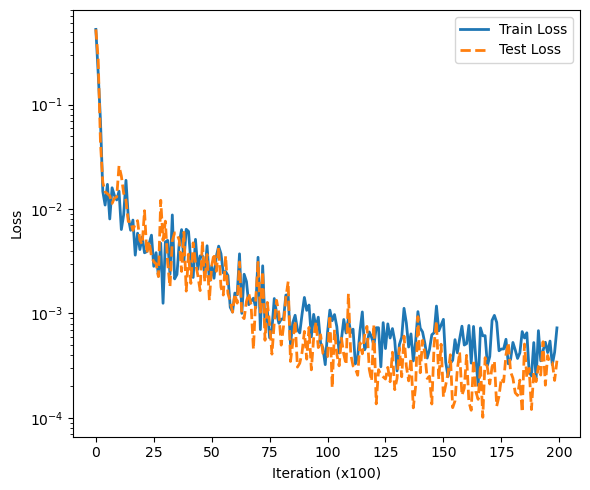

In [ ]:
# np.save("./parameters/PI-DeepONet_loss_log.npy", np.array(model.loss_log))
# np.save("./parameters/PI-DeepONet_test_loss_log.npy", np.array(model.test_loss_log))
PI_loss_log = np.load("./parameters/PI-DeepONet_loss_log.npy")
PI_test_loss_log = np.load("./parameters/PI-DeepONet_test_loss_log.npy")

#Plot for loss function
plt.figure(figsize=(6,5))
# plt.plot(model.loss_log, "-", lw=2, label='Train Loss')
# plt.plot(model.test_loss_log, "--", lw=2, label='Test Loss')
plt.plot(PI_loss_log, "-", lw=2, label='Train Loss')
plt.plot(PI_test_loss_log, "--", lw=2, label='Test Loss')
plt.xlabel('Iteration (x100)')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('./image/PI_POU_loss_curve.png', dpi=300)
plt.show()

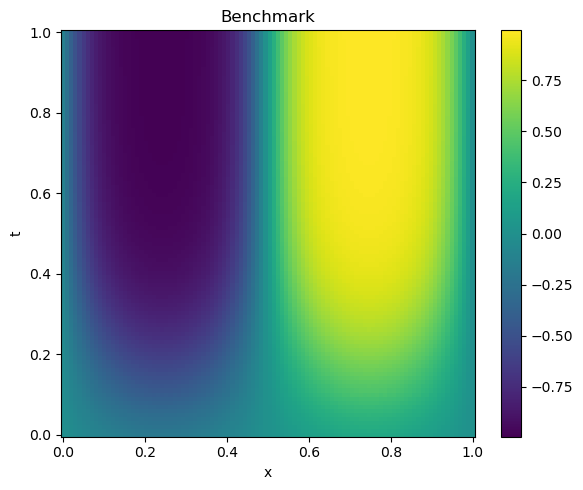

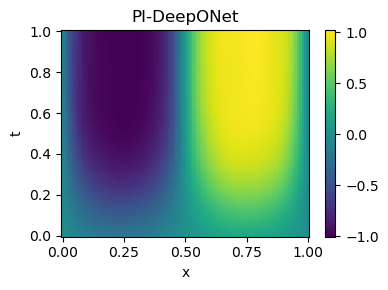

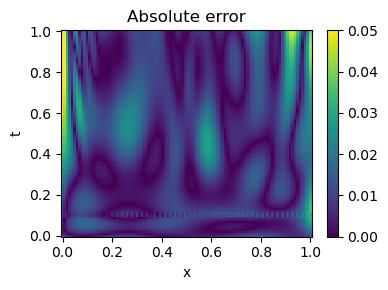

In [11]:
# Plot for one generated data
# usol = np.array( data['output'])
data = scipy.io.loadmat(path)
usol = np.array( data['output'])
usol = usol[:,1:1001:10,:]

k = 5 # index
u = usol[k,:, :]
u0 = usol[k,0,:]

P_test = 100

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]

s_pred = model.predict_s(params, u_test, y_test)[:,None]
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')


# error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2) 

# 创建并显示完整图形
fig = plt.figure(figsize=(6,5))

# plt.subplot(1,3,1)
plt.pcolor(T, X, u, cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Benchmark')
plt.colorbar()
plt.tight_layout()
plt.savefig("./image/Exact_AL")

fig = plt.figure(figsize=(4,3))
# plt.subplot(1,3,2)
plt.pcolor(T, X, S_pred.T, cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PI-DeepONet')
plt.colorbar()
plt.tight_layout()
# plt.savefig("./image/PI-DeepONet_predicted_AL")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
# plt.subplot(1,3,3)
plt.pcolor(T, X, np.abs(S_pred.T - u), cmap='viridis',vmin = 0,vmax = 0.05)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
# plt.savefig("./image/PI-DeepONet_error_AL")
plt.show()

# np.save("./parameters/PI-DeepONet_pre_AL",S_pred.T)
# np.save("./parameters/PI-DeepONet_error_AL",np.abs(S_pred.T - u))

In [12]:
# ...existing code...

# 计算 t=1 时，x在[0,1]上每隔0.2的预测误差
x_points = np.arange(0, 1.01, 0.2)
t_point = 0.9

# 找到对应的索引
t_idx = np.argmin(np.abs(t - t_point))
x_indices = [np.argmin(np.abs(x - xp)) for xp in x_points]
a = 0
print("t=1时各x位置的预测误差：")
for xi, xp in zip(x_indices, x_points):
    exact = u[xi, t_idx]
    pred = S_pred.T[xi, t_idx]
    abs_err = np.abs(pred - exact)
    print(f"x={xp:.1f}: 预测值={pred:.4f}, 精确值={exact:.4f}, 绝对误差={abs_err:.4e}")
    a = a+abs_err
print(a/5)
# ...existing code...

t=1时各x位置的预测误差：
x=0.0: 预测值=0.1116, 精确值=0.1185, 绝对误差=6.9489e-03
x=0.2: 预测值=0.4312, 精确值=0.4205, 绝对误差=1.0689e-02
x=0.4: 预测值=0.7275, 精确值=0.7198, 绝对误差=7.6596e-03
x=0.6: 预测值=0.8552, 精确值=0.8353, 绝对误差=1.9889e-02
x=0.8: 预测值=0.8882, 精确值=0.8662, 绝对误差=2.1998e-02
x=1.0: 预测值=0.8982, 精确值=0.8726, 绝对误差=2.5556e-02
0.018548058


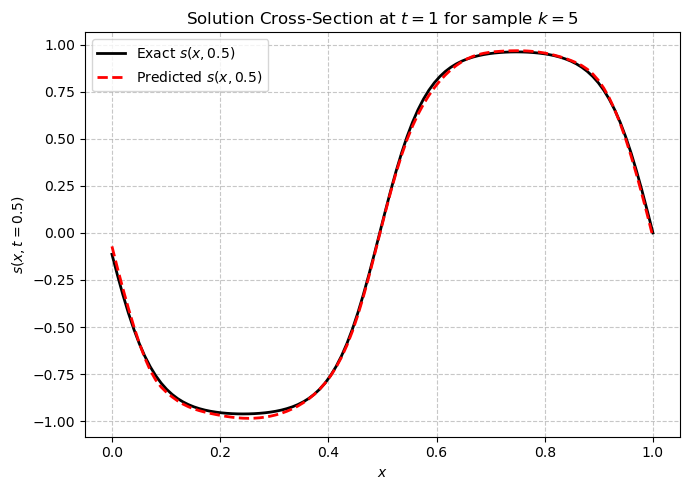

error: 0.9417658


In [ ]:
# ----------------------------------------------------------------
# 修改后的绘图部分：绘制 t=1 剖面图
# ----------------------------------------------------------------
P_test = 100

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]

s_pred = model.predict_s(params, u_test, y_test)[:,None]
# S_pred is the gridded prediction, shape (Nt, Nx)
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')


error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2) 
s_exact_t1 = u[50, :100]
s_pred_t1 = S_pred.T[50, :]
# np.save("./parameters/exact_AL_05",np.array(s_exact_t1))
# np.save("./parameters/PI-DeepONet_predicted_AL_05",np.array(s_pred_t1))
# 绘制 t=1 剖面图
fig = plt.figure(figsize=(7, 5))

# 绘制精确解
plt.plot(x, s_exact_t1, 'k-', linewidth=2, label='Exact $s(x, 0.5)$')

# 绘制预测解
plt.plot(x, s_pred_t1, 'r--', linewidth=2, label='Predicted $s(x, 0.5)$')

plt.xlabel('$x$')
plt.ylabel('$s(x, t=0.5)$')
plt.title(f'Solution Cross-Section at $t=1$ for sample $k={k}$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# 替换原来的 plt.show()
plt.show() 
plt.close()


# 5. 计算均方误差 (MSE)
# error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
error = np.mean((s_test - s_pred) ** 2) 
print("error:",error)

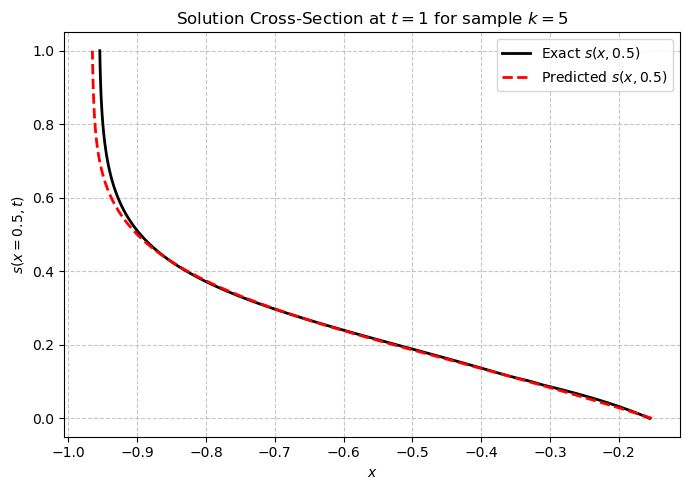

error: 0.9417658


In [ ]:

P_test = 100

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]

s_pred = model.predict_s(params, u_test, y_test)[:,None]
# S_pred is the gridded prediction, shape (Nt, Nx)
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')


error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2) 
s_exact_x1 = u[:,35]
s_pred_x1 = S_pred.T[:,35]
# np.save("./parameters/exact_AL_x_35",np.array(s_exact_x1))
# np.save("./parameters/PI-DeepONet_predicted_AL_x_35",np.array(s_pred_x1))
#  绘制 t=1 剖面图
fig = plt.figure(figsize=(7, 5))

# 绘制精确解
plt.plot(s_exact_x1, t, 'k-', linewidth=2, label='Exact $s(x, 0.5)$')

# 绘制预测解
plt.plot(s_pred_x1, t, 'r--', linewidth=2, label='Predicted $s(x, 0.5)$')

plt.xlabel('$x$')
plt.ylabel('$s(x = 0.5, t)$')
plt.title(f'Solution Cross-Section at $t=1$ for sample $k={k}$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# 替换原来的 plt.show()
plt.show() 
plt.close()


# 5. 计算均方误差 (MSE)
# error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
error = np.mean((s_test - s_pred) ** 2) 
print("error:",error)